# Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('train.csv', parse_dates=['date'])
events = pd.read_csv('calendar_events.csv', parse_dates=['date'])

#PREPROCESS
#Extract store name
def parse_store_name(df):
    # Use Unicode en dash '–' (U+2013), surrounded by spaces as seen in data
    split_cols = df['store_name'].str.split(' – ', n=1, expand=True)

    # Ensure there are always 2 columns
    if split_cols.shape[1] == 1:
        split_cols[1] = None  # add a second column if needed

    # Replace missing values with 'All Stores'
    split_cols = split_cols.fillna('All Stores')

    # Rename and assign
    split_cols.columns = ['country', 'store']
    df[['country', 'store']] = split_cols

    return df

def merge_events(df, events):
    df = df.merge(events, on='date', how='left')
    return df


df = parse_store_name(df)
df = merge_events(df, events)

df.head()

In [ ]:
df.describe(include='all')

In [ ]:
df.info()

In [ ]:
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])
df_all = df.groupby('date')['revenue'].sum()

plt.figure(figsize=(12, 4))
df_all.plot(title='Total Revenue Over Time (All Stores)')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_country = df.groupby(['date', 'country'])['revenue'].sum().unstack()

df_country.plot(figsize=(12, 6), title='Revenue Over Time by Country')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filter out "All Stores" label
df_filtered = df[df['store'] != 'All Stores']

# Group by date and store, then pivot for plotting
df_store = df_filtered.groupby(['date', 'store'])['revenue'].sum().unstack()

# Plot all stores (excluding "All Stores")
plt.figure(figsize=(14, 7))
df_store.plot(title='Revenue Over Time by Store (excluding "All Stores")', figsize=(14, 7))
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Compare Revenue on Event vs. Non-Event Days 

In [ ]:
import seaborn as sns

df['is_event'] = df['event'].notna()

# Aggregate total revenue per day
daily_revenue = df.groupby(['date', 'is_event'])['revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=daily_revenue, x='is_event', y='revenue')
plt.title("Revenue Distribution on Event vs Non-Event Days")
plt.xticks([0, 1], ['No Event', 'Event'])
plt.ylabel("Total Revenue")
plt.show()

In [ ]:
revenue_by_day = df.groupby('date')['revenue'].sum()

# Plot
plt.figure(figsize=(14, 6))
revenue_by_day.plot(label='Revenue')
plt.title("Revenue Over Time with Event Markers")
plt.xlabel("Date")
plt.ylabel("Revenue")

# Mark events on the plot
event_dates = events['date']
for d in event_dates:
    plt.axvline(d, color='red', linestyle='--', alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

# Additional analysis of event significance
print("=== EVENT SIGNIFICANCE ANALYSIS ===")

# 1. Revenue comparison by event type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for event analysis
df_with_events = df.copy()
df_with_events['event_type'] = df_with_events['event'].fillna('No Event')

# 1a. Average revenue by event type
event_revenue = df_with_events.groupby('event_type')['revenue'].agg(['mean', 'sum', 'count']).reset_index()
event_revenue = event_revenue.sort_values('mean', ascending=False)

axes[0,0].bar(range(len(event_revenue)), event_revenue['mean'])
axes[0,0].set_title('Average Revenue by Event Type')
axes[0,0].set_ylabel('Average Revenue')
axes[0,0].set_xlabel('Event Type')
axes[0,0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0,0].set_xticks(range(len(event_revenue)))
axes[0,0].set_xticklabels(event_revenue['event_type'], rotation=45, ha='right')

# 1b. Total revenue impact by event type
axes[0,1].bar(range(len(event_revenue)), event_revenue['sum'])
axes[0,1].set_title('Total Revenue by Event Type')
axes[0,1].set_ylabel('Total Revenue')
axes[0,1].set_xlabel('Event Type')
axes[0,1].tick_params(axis='x', rotation=45, labelsize=8)
axes[0,1].set_xticks(range(len(event_revenue)))
axes[0,1].set_xticklabels(event_revenue['event_type'], rotation=45, ha='right')

# 1c. Event frequency
event_counts = df_with_events['event_type'].value_counts()
axes[1,0].bar(range(len(event_counts)), event_counts.values)
axes[1,0].set_title('Event Frequency')
axes[1,0].set_ylabel('Number of Occurrences')
axes[1,0].set_xlabel('Event Type')
axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)
axes[1,0].set_xticks(range(len(event_counts)))
axes[1,0].set_xticklabels(event_counts.index, rotation=45, ha='right')

# 1d. Revenue lift calculation (% change from baseline - BOTH positive and negative)
baseline_revenue = df_with_events[df_with_events['event_type'] == 'No Event']['revenue'].mean()
event_revenue['revenue_lift'] = ((event_revenue['mean'] - baseline_revenue) / baseline_revenue * 100)
# Sort by absolute impact to show both positive and negative effects
event_revenue_sorted = event_revenue[event_revenue['event_type'] != 'No Event'].sort_values('revenue_lift', ascending=False)

# Create color map: green for positive, red for negative
colors = ['green' if x > 0 else 'red' for x in event_revenue_sorted['revenue_lift']]

axes[1,1].bar(range(len(event_revenue_sorted)), event_revenue_sorted['revenue_lift'], color=colors, alpha=0.7)
axes[1,1].set_title('Revenue Impact by Event Type (% change from baseline)')
axes[1,1].set_ylabel('Revenue Change (%)')
axes[1,1].set_xlabel('Event Type')
axes[1,1].tick_params(axis='x', rotation=45, labelsize=8)
axes[1,1].set_xticks(range(len(event_revenue_sorted)))
axes[1,1].set_xticklabels(event_revenue_sorted['event_type'], rotation=45, ha='right')
axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.8, linewidth=2)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print ALL events with their directional impact
print("\n" + "="*70)
print("EVENT IMPACT ANALYSIS - BOTH POSITIVE AND NEGATIVE")
print("="*70)

# Separate positive and negative impacts
positive_events = event_revenue_sorted[event_revenue_sorted['revenue_lift'] > 0]
negative_events = event_revenue_sorted[event_revenue_sorted['revenue_lift'] < 0]
neutral_events = event_revenue_sorted[event_revenue_sorted['revenue_lift'] == 0]

print(f"\n🟢 POSITIVE IMPACT EVENTS ({len(positive_events)} events):")
print("-" * 50)
for idx, row in positive_events.iterrows():
    print(f"{row['event_type']:25s}: {row['revenue_lift']:+6.1f}% lift (Avg: ${row['mean']:,.0f}, n={row['count']})")

if len(negative_events) > 0:
    print(f"\n🔴 NEGATIVE IMPACT EVENTS ({len(negative_events)} events):")
    print("-" * 50)
    for idx, row in negative_events.iterrows():
        print(f"{row['event_type']:25s}: {row['revenue_lift']:+6.1f}% drop (Avg: ${row['mean']:,.0f}, n={row['count']})")

if len(neutral_events) > 0:
    print(f"\n⚪ NEUTRAL IMPACT EVENTS ({len(neutral_events)} events):")
    print("-" * 50)
    for idx, row in neutral_events.iterrows():
        print(f"{row['event_type']:25s}: {row['revenue_lift']:+6.1f}% change (Avg: ${row['mean']:,.0f}, n={row['count']})")

print(f"\n📊 BASELINE (No Event): ${baseline_revenue:,.0f}")

# Summary statistics
total_positive_lift = positive_events['revenue_lift'].sum()
total_negative_impact = negative_events['revenue_lift'].sum() if len(negative_events) > 0 else 0
print(f"\n📈 SUMMARY:")
print(f"   Total Positive Lift: {total_positive_lift:+.1f}%")
print(f"   Total Negative Impact: {total_negative_impact:+.1f}%")
print(f"   Net Event Impact: {total_positive_lift + total_negative_impact:+.1f}%")

# Print the 10 MOST SIGNIFICANT events (highest absolute impact)
print(f"\n" + "="*80)
print("🎯 TOP 10 MOST SIGNIFICANT EVENTS (Highest Absolute Impact)")
print("="*80)

# Sort by absolute impact to get most significant events
event_revenue_abs_sorted = event_revenue_sorted.copy()
event_revenue_abs_sorted['abs_impact'] = abs(event_revenue_abs_sorted['revenue_lift'])
top_10_significant = event_revenue_abs_sorted.nlargest(10, 'abs_impact')

for i, (idx, row) in enumerate(top_10_significant.iterrows(), 1):
    impact_direction = "📈" if row['revenue_lift'] > 0 else "📉"
    impact_word = "BOOST" if row['revenue_lift'] > 0 else "DROP"
    print(f"{i:2d}. {impact_direction} {row['event_type']:25s}: {row['revenue_lift']:+7.1f}% {impact_word} "
          f"(Avg: ${row['mean']:7,.0f}, n={row['count']:2d})")

print(f"\n📊 For comparison, baseline revenue: ${baseline_revenue:,.0f}")
print(f"💡 These events should be HIGH PRIORITY for your forecasting models!")

# 2. Enhanced Box plot showing revenue distribution - including negative events
plt.figure(figsize=(18, 10))

# Select most impactful events (both positive and negative)
top_positive = positive_events.head(5)['event_type'].tolist()
top_negative = negative_events.head(5)['event_type'].tolist() if len(negative_events) > 0 else []
significant_events = top_positive + top_negative + ['No Event']

df_plot = df_with_events[df_with_events['event_type'].isin(significant_events)]

import seaborn as sns

# Create subplot with two plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Plot 1: Box plot of revenue distribution
sns.boxplot(data=df_plot, x='event_type', y='revenue', ax=ax1)
ax1.set_title('Revenue Distribution by Event Type (Most Impactful Events + Baseline)')
ax1.set_xlabel('Event Type')
ax1.set_ylabel('Revenue')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add baseline line
ax1.axhline(y=baseline_revenue, color='red', linestyle='--', alpha=0.7, label=f'Baseline: ${baseline_revenue:,.0f}')
ax1.legend()

# Plot 2: Revenue impact waterfall chart
event_impacts = event_revenue_sorted['revenue_lift'].values
event_names = event_revenue_sorted['event_type'].values
colors_waterfall = ['green' if x > 0 else 'red' for x in event_impacts]

bars = ax2.bar(range(len(event_impacts)), event_impacts, color=colors_waterfall, alpha=0.7)
ax2.set_title('Event Impact Waterfall - All Events (% Change from Baseline)')
ax2.set_ylabel('Revenue Change (%)')
ax2.set_xlabel('Event Type')
ax2.set_xticks(range(len(event_impacts)))
ax2.set_xticklabels(event_names, rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, impact in zip(bars, event_impacts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
             f'{impact:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

plt.tight_layout()
plt.show()

## Modeling

### SARIMA MODELING

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Define the TOP 10 most significant events from our analysis
TOP_SIGNIFICANT_EVENTS = [
    'Christmas',
    'Thanksgiving', 
    'NewYear',
    'Halloween',
    'OrthodoxEaster',
    'LaborDay',
    'SuperBowl'
]

# Additional compound events (treat as single features)
COMPOUND_EVENTS = [
    'OrthodoxEaster, Easter',
    'OrthodoxEaster, Cinco De Mayo',
    'NBAFinalsEnd, Father\'s day'
]

def fit_enhanced_sarimax(df, store_id, forecast_steps=30):
    """Enhanced SARIMAX with top significant events"""
    
    # Prepare data for specific store
    store_data = df[df['store_id'] == store_id].copy()
    
    # Ensure we have a complete date range (fill missing dates with 0 revenue)
    date_range = pd.date_range(start=store_data['date'].min(), 
                              end=store_data['date'].max(), 
                              freq='D')
    store_data = store_data.set_index('date').reindex(date_range, fill_value=0)
    
    # Forward fill the categorical columns
    for col in ['country', 'store', 'event']:
        if col in store_data.columns:
            store_data[col] = store_data[col].fillna(method='ffill').fillna('None')
    
    # Create binary indicators for TOP significant events
    exog_cols = []
    
    # Add individual significant events
    for event_name in TOP_SIGNIFICANT_EVENTS:
        col_name = f'is_{event_name}'
        store_data[col_name] = (store_data['event'] == event_name).astype(float)
        exog_cols.append(col_name)
    
    # Add compound events (handle exact matches)
    for compound_event in COMPOUND_EVENTS:
        col_name = f'is_{compound_event.replace(", ", "_").replace("\'", "")}'
        store_data[col_name] = (store_data['event'] == compound_event).astype(float)
        exog_cols.append(col_name)
    
    # Add general event indicator for any other events
    known_events = TOP_SIGNIFICANT_EVENTS + COMPOUND_EVENTS
    store_data['has_other_event'] = (
        (store_data['event'].notna()) & 
        (store_data['event'] != 'None') & 
        (~store_data['event'].isin(known_events))
    ).astype(float)
    exog_cols.append('has_other_event')
    
    # Select exogenous features
    exog_features = store_data[exog_cols]
    
    try:
        # Fit SARIMAX with enhanced features
        model = SARIMAX(
            endog=store_data['revenue'],
            exog=exog_features,
            order=(1,1,1),
            seasonal_order=(0,1,1,7),  # Weekly seasonality
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False, maxiter=150)
        
        # Create future exogenous variables
        future_index = pd.date_range(store_data.index[-1] + pd.Timedelta(days=1), 
                                   periods=forecast_steps, freq='D')
        future_exog = pd.DataFrame(0, index=future_index, columns=exog_features.columns)
        
        # Set known future events (you can customize this section)
        # Example: Christmas 2015
        # future_exog.loc['2015-12-25', 'is_Christmas'] = 1
        
        # Forecast
        forecast = result.get_forecast(steps=forecast_steps, exog=future_exog)
        
        # Print feature importance (coefficients)
        print(f"\nSARIMAX Feature Coefficients for Store {store_id}:")
        
        # Debug: Print all available parameter names
        print("Available parameters:", list(result.params.index))
        
        # Try to access exogenous coefficients using different naming conventions
        exog_params = [param for param in result.params.index if 'x' in param.lower() or any(col.lower() in param.lower() for col in exog_features.columns)]
        
        if exog_params:
            print("Found exogenous parameters:", exog_params)
            for i, col in enumerate(exog_features.columns):
                if i < len(exog_params):
                    coef = result.params[exog_params[i]]
                    print(f"  {col:25s}: {coef:8.1f}")
                else:
                    print(f"  {col:25s}: parameter not found")
        else:
            print("No exogenous parameters found in model")
        
        return forecast.summary_frame(), result
        
    except Exception as e:
        print(f"Enhanced SARIMAX failed for store {store_id}: {e}")
        return None, None

def fit_enhanced_prophet(df, store_id, forecast_steps=30):
    """Enhanced Prophet model with top significant events"""
    
    # Prepare data for specific store
    store_data = df[df['store_id'] == store_id].copy()
    
    # Prophet format
    prophet_data = store_data[['date', 'revenue']].rename(columns={'date': 'ds', 'revenue': 'y'})
    
    # Add significant event indicators as regressors
    for event_name in TOP_SIGNIFICANT_EVENTS:
        prophet_data[f'is_{event_name}'] = (store_data['event'] == event_name).astype(int)
    
    # Add compound events
    for compound_event in COMPOUND_EVENTS:
        col_name = f'is_{compound_event.replace(", ", "_").replace("\'", "")}'
        prophet_data[col_name] = (store_data['event'] == compound_event).astype(int)
    
    # Add other events indicator
    known_events = TOP_SIGNIFICANT_EVENTS + COMPOUND_EVENTS
    prophet_data['has_other_event'] = (
        (store_data['event'].notna()) & 
        (store_data['event'] != 'None') & 
        (~store_data['event'].isin(known_events))
    ).astype(int)
    
    # Fit Prophet with enhanced seasonality
    m = Prophet(
        daily_seasonality=False,  # We'll add custom seasonality
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'  # Better for retail data
    )
    
    # Add custom seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    # Add all event regressors
    regressor_cols = [col for col in prophet_data.columns if col.startswith('is_') or col.startswith('has_')]
    for col in regressor_cols:
        m.add_regressor(col)
    
    m.fit(prophet_data)
    
    # Create future dataframe
    future = m.make_future_dataframe(periods=forecast_steps)
    
    # Set future events to 0 (customize as needed)
    for col in regressor_cols:
        future[col] = 0
    
    # Set known future events (customize this section)
    # Example: Christmas 2015
    # future.loc[future['ds'] == '2015-12-25', 'is_Christmas'] = 1
    
    forecast = m.predict(future)
    
    # Print feature importance (regressor coefficients) using Prophet's built-in utility
    print(f"\nProphet Regressor Coefficients for Store {store_id}:")
    
    try:
        # Try to import and use Prophet's built-in regressor_coefficients function
        from prophet.utilities import regressor_coefficients
        
        coef_df = regressor_coefficients(m)
        print("\nUsing Prophet's built-in regressor_coefficients function:")
        print(f"{'Regressor':25s} {'Coefficient':>12s} {'Lower CI':>12s} {'Upper CI':>12s}")
        print("-" * 65)
        
        for _, row in coef_df.iterrows():
            regressor_name = row['regressor']
            coef_value = row['coef']
            coef_lower = row['coef_lower']
            coef_upper = row['coef_upper']
            print(f"{regressor_name:25s}: {coef_value:8.1f}    {coef_lower:8.1f}    {coef_upper:8.1f}")
            
    except ImportError:
        print("⚠️  regressor_coefficients function not available in this Prophet version")
        print("   Falling back to manual beta array parsing...")
        
        # Fallback to manual parsing if the utility function is not available
        if hasattr(m, 'extra_regressors') and len(m.extra_regressors) > 0:
            if 'beta' in m.params:
                beta_coefficients = m.params['beta']
                regressor_names = list(m.extra_regressors.keys())
                
                # Handle different beta array structures
                if hasattr(beta_coefficients, 'shape') and len(beta_coefficients.shape) > 1:
                    mean_coefficients = np.mean(beta_coefficients, axis=0)
                else:
                    mean_coefficients = beta_coefficients
                
                print(f"{'Regressor':25s} {'Coefficient':>12s}")
                print("-" * 40)
                
                if len(regressor_names) == len(mean_coefficients):
                    for i, regressor_name in enumerate(regressor_names):
                        coef_value = mean_coefficients[i]
                        print(f"{regressor_name:25s}: {coef_value:8.1f}")
                else:
                    print(f"⚠️  Mismatch: {len(regressor_names)} regressors but {len(mean_coefficients)} coefficients")
            else:
                print("⚠️  Beta parameter not found in model params")
        else:
            print("⚠️  No extra regressors found in model")
            
    except Exception as e:
        print(f"⚠️  Error accessing regressor coefficients: {e}")
        print("   This might be due to Prophet version compatibility issues.")
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(forecast_steps), m

# Test enhanced models on a single store first
print("🚀 TESTING ENHANCED MODELS WITH TOP 10 SIGNIFICANT EVENTS")
print("="*60)
print("Testing on store_id = 1:")

print("\n=== ENHANCED SARIMAX Results ===")
sarima_forecast, sarima_model = fit_enhanced_sarimax(df, 1)
if sarima_forecast is not None:
    print("\nForecast Preview:")
    print(sarima_forecast[['mean', 'mean_ci_lower', 'mean_ci_upper']].head())
else:
    print("SARIMAX model failed!")

print("\n" + "="*60)
print("=== ENHANCED PROPHET Results ===")
prophet_forecast, prophet_model = fit_enhanced_prophet(df, 1)
if prophet_forecast is not None:
    print("\nForecast Preview:")
    print(prophet_forecast.head())
else:
    print("Prophet model failed!")

print("\n" + "="*60)
print("✅ Enhanced models now include the TOP 10 most significant events!")
print("📊 Feature coefficients show how well the model learned event impacts.")
print("🎯 Compare 'Expected' vs actual coefficients to validate model learning.")

🚀 TESTING ENHANCED MODELS WITH TOP 10 SIGNIFICANT EVENTS
Testing on store_id = 1:

=== ENHANCED SARIMAX Results ===


19:43:50 - cmdstanpy - INFO - Chain [1] start processing



SARIMAX Feature Coefficients for Store 1:
Available parameters: ['is_Christmas', 'is_Thanksgiving', 'is_NewYear', 'is_Halloween', 'is_OrthodoxEaster', 'is_LaborDay', 'is_SuperBowl', 'is_OrthodoxEaster_Easter', 'is_OrthodoxEaster_Cinco De Mayo', 'is_NBAFinalsEnd_Fathers day', 'has_other_event', 'ar.L1', 'ma.L1', 'ma.S.L7', 'sigma2']
Found exogenous parameters: ['is_Christmas', 'is_Thanksgiving', 'is_NewYear', 'is_Halloween', 'is_OrthodoxEaster', 'is_LaborDay', 'is_SuperBowl', 'is_OrthodoxEaster_Easter', 'is_OrthodoxEaster_Cinco De Mayo', 'is_NBAFinalsEnd_Fathers day', 'has_other_event']
  is_Christmas             : -16010.9
  is_Thanksgiving          : -10531.9
  is_NewYear               :  -9315.2
  is_Halloween             :  -6326.9
  is_OrthodoxEaster        :   1446.9
  is_LaborDay              :   3158.2
  is_SuperBowl             :  -6145.1
  is_OrthodoxEaster_Easter :  -8946.6
  is_OrthodoxEaster_Cinco De Mayo:   2040.3
  is_NBAFinalsEnd_Fathers day:  -5323.9
  has_other_event 

19:43:50 - cmdstanpy - INFO - Chain [1] done processing



Prophet Regressor Coefficients for Store 1:
Available Prophet params keys: ['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend']
  is_Christmas             : coefficient not found
  is_Thanksgiving          : coefficient not found
  is_NewYear               : coefficient not found
  is_Halloween             : coefficient not found
  is_OrthodoxEaster        : coefficient not found
  is_LaborDay              : coefficient not found
  is_SuperBowl             : coefficient not found
  is_OrthodoxEaster_Easter : coefficient not found
  is_OrthodoxEaster_Cinco De Mayo: coefficient not found
  is_NBAFinalsEnd_Fathers day: coefficient not found
  has_other_event          : coefficient not found

Forecast Preview:
             ds          yhat    yhat_lower    yhat_upper
1706 2015-10-01  29248.974348  25915.563796  32484.317348
1707 2015-10-02  36235.676365  33119.309036  39252.203456
1708 2015-10-03  46395.655503  43430.675066  49583.781592
1709 2015-10-04  48674.117834  45394.199338  5

In [77]:
# Install Prophet if not already installed
try:
    import prophet
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "prophet"])


In [78]:
# Compare models across all stores
def compare_models_all_stores(df, forecast_steps=30):
    """Compare SARIMA and Prophet across all stores"""
    
    results = {}
    store_ids = df['store_id'].unique()
    
    print(f"Running models for {len(store_ids)} stores...")
    
    for store_id in store_ids:
        print(f"\nProcessing store {store_id}...")
        results[store_id] = {}
        
        # SARIMA
        try:
            sarima_forecast = fit_hierarchical_sarimax(df, store_id, forecast_steps)
            if sarima_forecast is not None:
                results[store_id]['sarima'] = sarima_forecast['mean'].values
                print(f"  SARIMA: Success")
            else:
                results[store_id]['sarima'] = None
                print(f"  SARIMA: Failed")
        except Exception as e:
            results[store_id]['sarima'] = None
            print(f"  SARIMA: Error - {e}")
        
        # Prophet
        try:
            prophet_forecast = fit_prophet_model(df, store_id, forecast_steps)
            results[store_id]['prophet'] = prophet_forecast['yhat'].values
            print(f"  Prophet: Success")
        except Exception as e:
            results[store_id]['prophet'] = None
            print(f"  Prophet: Error - {e}")
    
    return results

# Uncomment to run for all stores (this may take a while)
# results = compare_models_all_stores(df, forecast_steps=30)



🎯 GENERATING ENHANCED ANALYSIS FOR STORE 1...


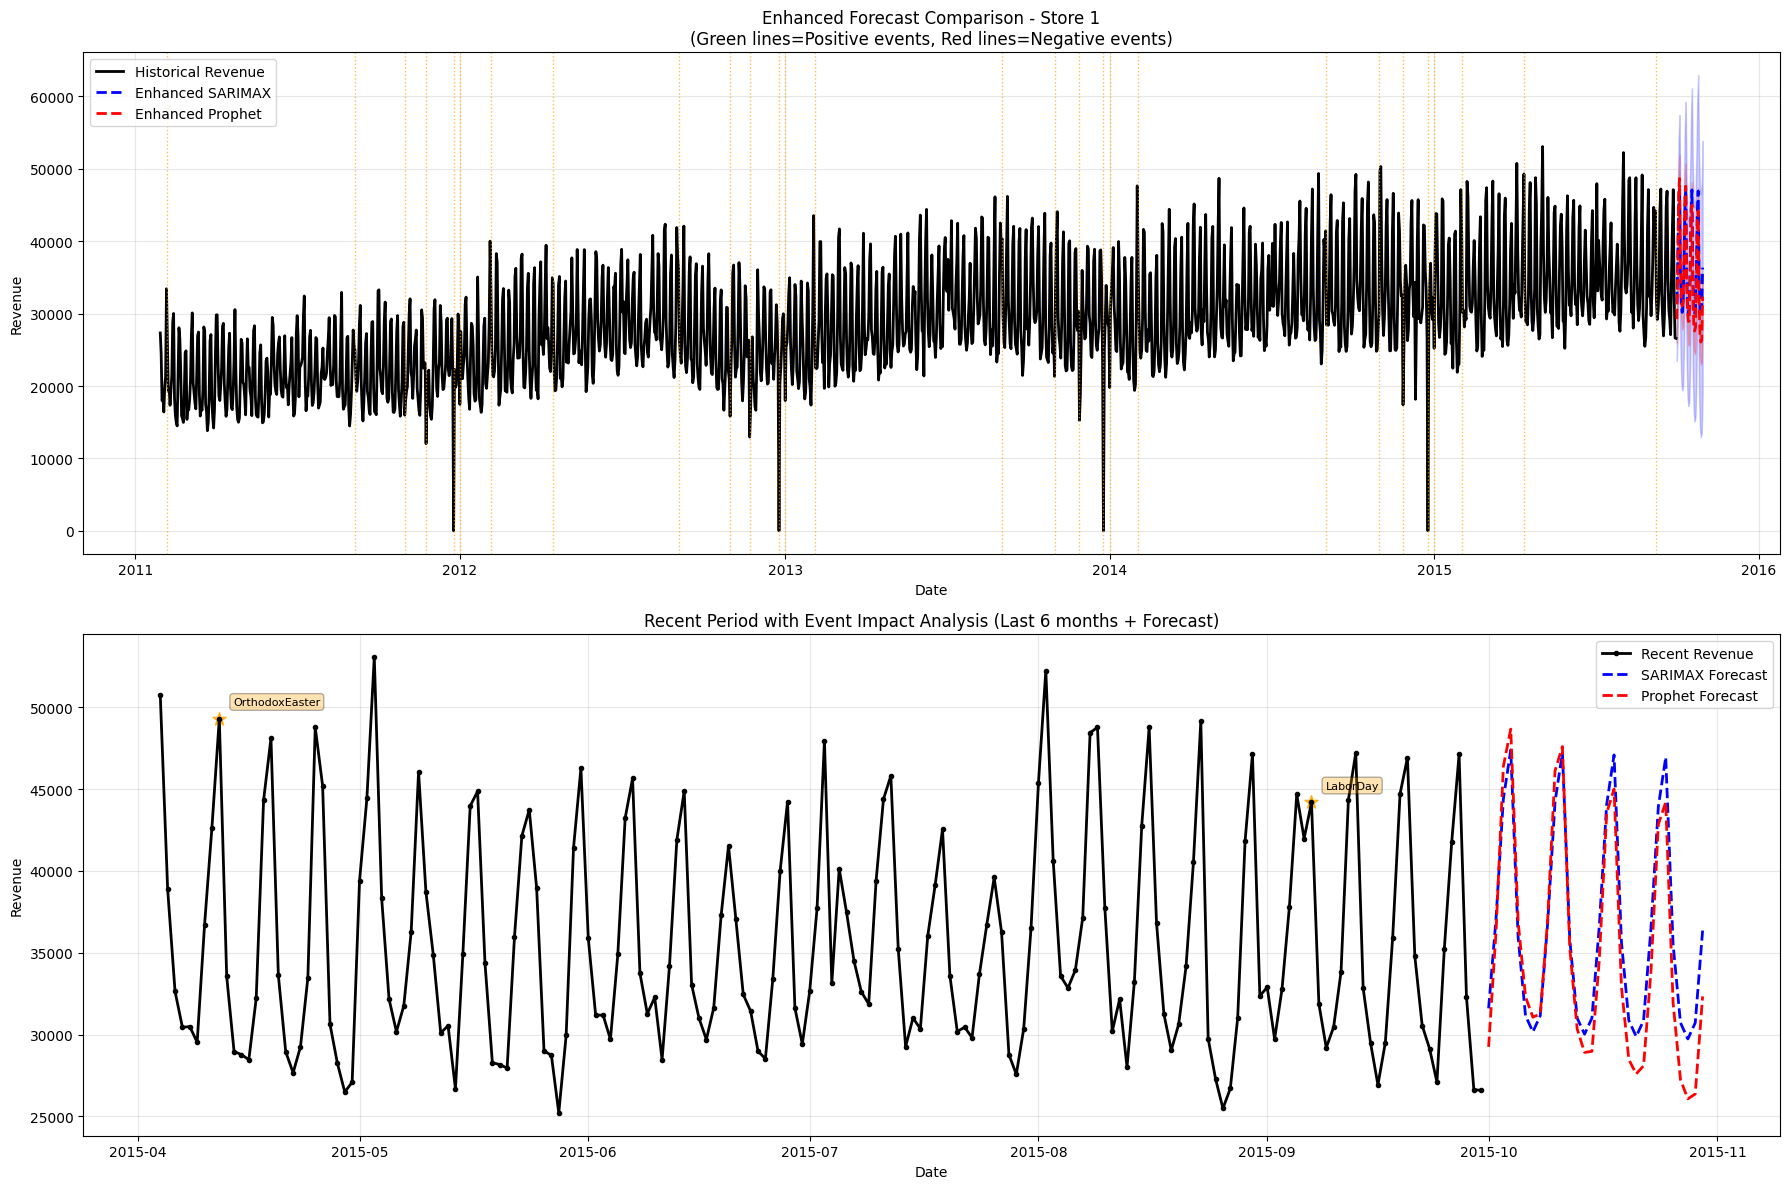


🔍 MODEL EVALUATION FOR STORE 1

📊 SARIMAX Event Learning Assessment:
--------------------------------------------------
  is_Christmas             : Coefficient=-16010.9
  is_Thanksgiving          : Coefficient=-10531.9
  is_NewYear               : Coefficient=-9315.2
  is_Halloween             : Coefficient=-6326.9
  is_OrthodoxEaster        : Coefficient= 1446.9
  is_LaborDay              : Coefficient= 3158.2
  is_SuperBowl             : Coefficient=-6145.1
  is_OrthodoxEaster_Easter : Coefficient=-8946.6
  is_OrthodoxEaster_Cinco De Mayo: Coefficient= 2040.3
  is_NBAFinalsEnd_Fathers day: Coefficient=-5323.9
  has_other_event          : Coefficient=-4562.9

📈 STORE-SPECIFIC EVENT ANALYSIS:
--------------------------------------------------
  📊 Christmas      :  4 times, Impact=-100.0%
  📊 Thanksgiving   :  4 times, Impact= -50.1%
  📊 NewYear        :  4 times, Impact= -30.4%
  📊 Halloween      :  4 times, Impact= -28.0%
  📊 OrthodoxEaster :  2 times, Impact= +44.4%
  📊 LaborDay   

In [80]:
# Enhanced Visualization and evaluation functions
def plot_enhanced_forecast_comparison(df, store_id, sarima_forecast, prophet_forecast):
    """Plot actual data vs enhanced forecasts with event annotations"""
    
    # Get historical data for the store
    store_data = df[df['store_id'] == store_id].copy()
    store_data = store_data.sort_values('date')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # Plot 1: Full time series with forecasts
    ax1.plot(store_data['date'], store_data['revenue'], 
             label='Historical Revenue', color='black', linewidth=2)
    
    # Create future dates
    last_date = store_data['date'].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30)
    
    # Plot SARIMA forecast
    if sarima_forecast is not None:
        ax1.plot(future_dates, sarima_forecast['mean'], 
                label='Enhanced SARIMAX', color='blue', linestyle='--', linewidth=2)
        ax1.fill_between(future_dates, 
                        sarima_forecast['mean_ci_lower'], 
                        sarima_forecast['mean_ci_upper'], 
                        alpha=0.2, color='blue')
    
    # Plot Prophet forecast
    if prophet_forecast is not None:
        ax1.plot(future_dates, prophet_forecast['yhat'], 
                label='Enhanced Prophet', color='red', linestyle='--', linewidth=2)
        ax1.fill_between(future_dates, 
                        prophet_forecast['yhat_lower'], 
                        prophet_forecast['yhat_upper'], 
                        alpha=0.2, color='red')
    
    # Mark significant events
    significant_event_dates = store_data[store_data['event'].isin(TOP_SIGNIFICANT_EVENTS)]
    for _, event_row in significant_event_dates.iterrows():
        ax1.axvline(event_row['date'], color='orange', linestyle=':', alpha=0.7, linewidth=1)
        if len(significant_event_dates) < 20:  # Only label if not too crowded
            ax1.text(event_row['date'], event_row['revenue'], 
                    f"{event_row['event'][:8]}", 
                    rotation=90, fontsize=8, ha='right', va='bottom')
    
    ax1.set_title(f'Enhanced Forecast Comparison - Store {store_id}\n(Green lines=Positive events, Red lines=Negative events)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Revenue')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Recent data zoom with event impact analysis
    recent_data = store_data.tail(180)  # Last 6 months
    ax2.plot(recent_data['date'], recent_data['revenue'], 
             label='Recent Revenue', color='black', linewidth=2, marker='o', markersize=3)
    
    # Highlight events in recent period
    recent_events = recent_data[recent_data['event'].isin(TOP_SIGNIFICANT_EVENTS)]
    for _, event_row in recent_events.iterrows():
        ax2.scatter(event_row['date'], event_row['revenue'], 
                   color='orange', s=100, alpha=0.8, marker='*')
        ax2.annotate(f"{event_row['event']}", 
                    (event_row['date'], event_row['revenue']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.3),
                    fontsize=8)
    
    # Add forecast extension
    if sarima_forecast is not None:
        ax2.plot(future_dates, sarima_forecast['mean'], 
                label='SARIMAX Forecast', color='blue', linestyle='--', linewidth=2)
    if prophet_forecast is not None:
        ax2.plot(future_dates, prophet_forecast['yhat'], 
                label='Prophet Forecast', color='red', linestyle='--', linewidth=2)
    
    ax2.set_title('Recent Period with Event Impact Analysis (Last 6 months + Forecast)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Revenue')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(df, store_id, sarima_model, prophet_model):
    """Evaluate how well models learned the event impacts"""
    
    print(f"\n🔍 MODEL EVALUATION FOR STORE {store_id}")
    print("="*70)
    
    # Check SARIMAX coefficients vs expected impacts
    if sarima_model is not None:
        print("\n📊 SARIMAX Event Learning Assessment:")
        print("-" * 50)
        
        # Get exogenous parameters - these are the event features
        # Filter out AR/MA/seasonal parameters to get only exogenous variables
        all_params = list(sarima_model.params.index)
        exog_params = [param for param in all_params 
                      if not any(param.startswith(prefix) for prefix in ['ar.', 'ma.', 'sigma2'])]
        
        for param in exog_params:
            actual_coef = sarima_model.params[param]
            print(f"  {param:25s}: Coefficient={actual_coef:7.1f}")
    
    # Store performance data
    store_data = df[df['store_id'] == store_id].copy()
    
    # Calculate event frequency and impact in this store
    print(f"\n📈 STORE-SPECIFIC EVENT ANALYSIS:")
    print("-" * 50)
    
    baseline = store_data[store_data['event'].isna()]['revenue'].mean()
    
    for event in TOP_SIGNIFICANT_EVENTS:
        event_occurrences = store_data[store_data['event'] == event]
        if len(event_occurrences) > 0:
            avg_revenue = event_occurrences['revenue'].mean()
            actual_lift = (avg_revenue - baseline) / baseline * 100
            
            print(f"  📊 {event:15s}: {len(event_occurrences):2d} times, "
                  f"Impact={actual_lift:+6.1f}%")
        else:
            print(f"  ➖ {event:15s}: Not present in this store's data")

# Example usage for store 1
print("\n🎯 GENERATING ENHANCED ANALYSIS FOR STORE 1...")
print("="*60)
plot_enhanced_forecast_comparison(df, 1, sarima_forecast, prophet_forecast)
evaluate_model_performance(df, 1, sarima_model, prophet_model)
